2026-02-27 11:01:20 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.
2026-02-27 11:01:20 [WARNING] [commstools/core.py] SingleCarrierFrame (comb): payload_len=800000 is not divisible by data_per_period=9 (pilot_period=10). Snapping payload_len 800000 → 800001 so that num_pilot_periods == num_data_periods == 88889.


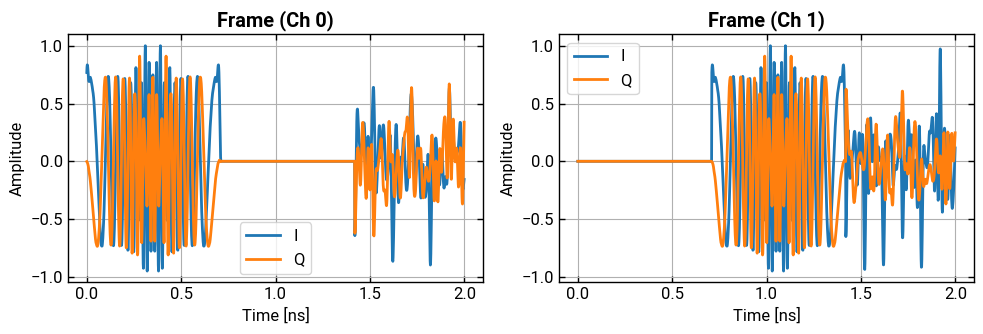

In [ ]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("INFO")


symbol_rate = 100e9
sampling_rate = 800e9
sps = int(sampling_rate / symbol_rate)
pilots_mod_scheme = "psk"
pilots_mod_order = 8
payload_mod_scheme = "qam"
payload_mod_order = 32

p = Preamble(sequence_type="zc", length=71)

f = SingleCarrierFrame(
    payload_len=800000,
    payload_seed=42,
    payload_mod_scheme=payload_mod_scheme,
    payload_mod_order=payload_mod_order,
    preamble=p,
    preamble_mode="time_orthogonal",
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme=pilots_mod_scheme,
    pilot_mod_order=pilots_mod_order,
    pilot_gain_db=10.0,
    num_streams=2,
)

fs = f.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_waveform(show=True, num_symbols=200, title="Frame")


In [ ]:
fs.print_info()


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),None / None
3,Symbol Rate,100.00 GBaud
4,Bit Rate,None
5,Sampling Rate,800.00 GHz
6,Samples Per Symbol,8.00
7,Pulse Shape,RRC
8,Duration,8.89 µs
9,Center Frequency,0.00 Hz


2026-02-27 10:20:44 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 30.00 dB).
2026-02-27 10:20:44 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


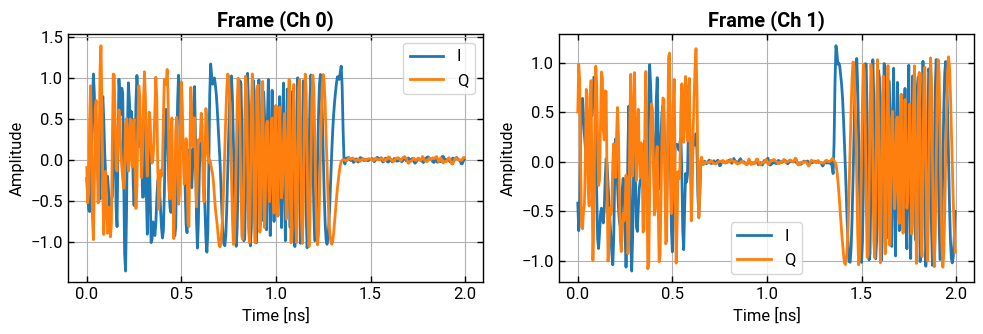

2026-02-27 10:20:46 [INFO] [commstools/sync.py] Channels aligned (spread 0).


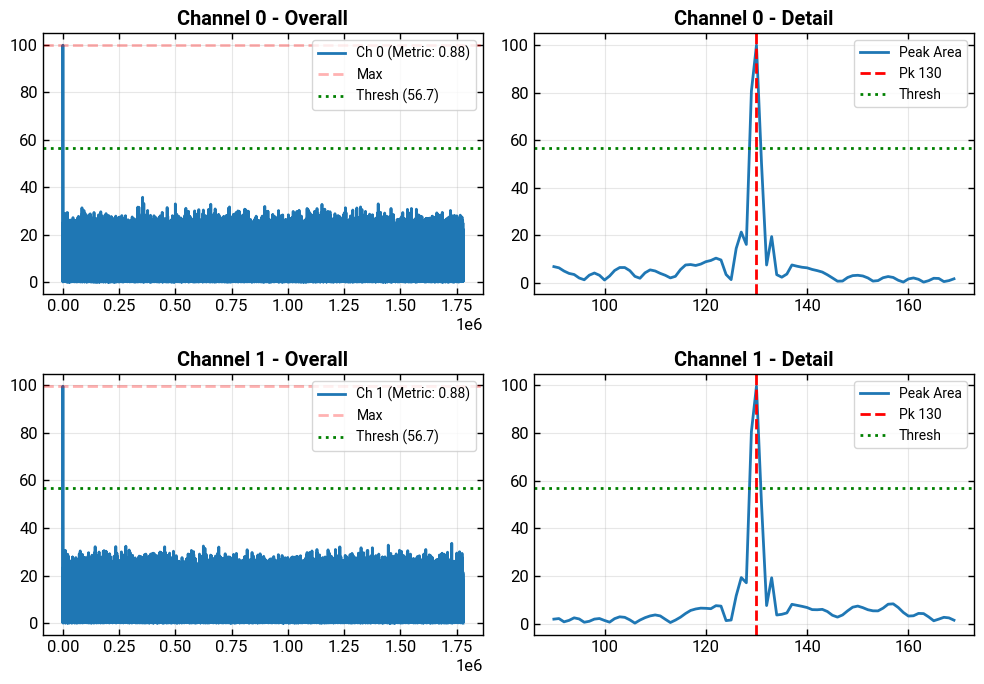

2026-02-27 10:20:48 [INFO] [commstools/sync.py] Timing estimated. Coarse: [130, 130], Fractional: [-0.2454472916032362, -0.2469978418275982], Metrics: [0.8799835422591067, 0.8787481119230887]


In [3]:
from commstools.backend import get_array_module
from commstools.impairments import apply_awgn
from commstools.sync import correct_timing, estimate_timing

rxfs = fs.copy()
xp = get_array_module(rxfs.samples)

rxfs.samples = apply_awgn(rxfs.samples, esn0_db=30, sps=rxfs.sps)
rxfs.samples = xp.roll(rxfs.samples, 519, axis=-1)
rxfs.resample(sps_out=2)

rxfs.matched_filter()
rxfs.plot_waveform(show=True, num_symbols=200, title="Frame")

fix = estimate_timing(rxfs, p, debug_plot=True, dft_upsample=16)
# print(fix)


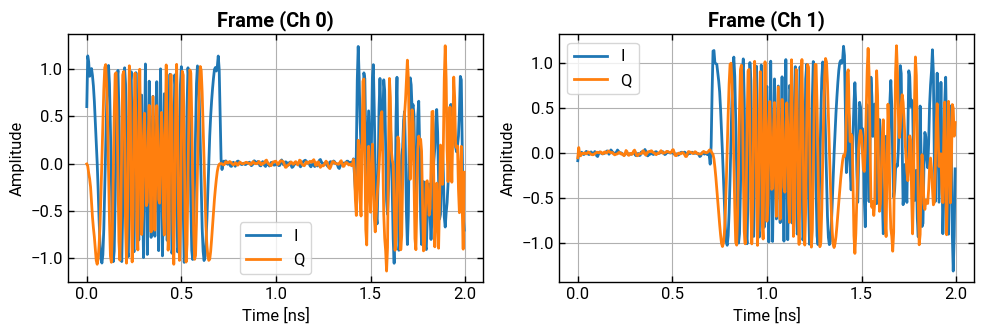

In [4]:
rxfs.samples = correct_timing(rxfs.samples, fix[0], fix[1])

rxfs.plot_waveform(show=True, num_symbols=200, title="Frame")


In [5]:
ps = p.to_signal(sps=rxfs.sps, symbol_rate=symbol_rate, pulse_shape="rrc")

rxfs.samples = rxfs.samples[:, 2 * ps.samples.shape[-1] :]


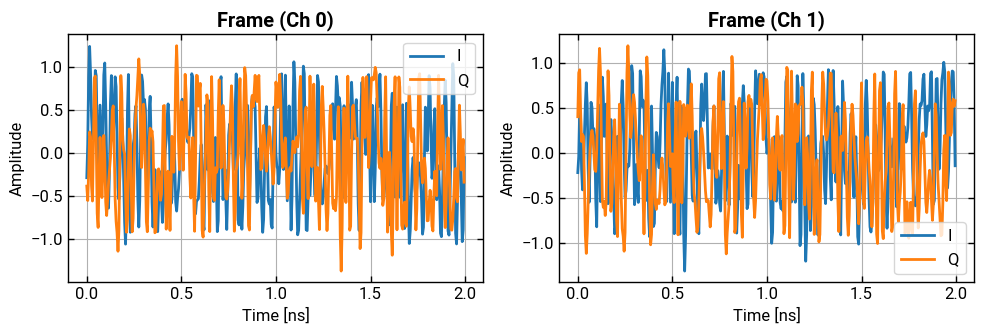

In [6]:
rxfs.plot_waveform(show=True, num_symbols=200, title="Frame")


In [7]:
rxfs.decimate_to_symbol_rate(offset=0)
map = f.get_structure_map(unit="samples", sps=rxfs.sps, include_preamble=False)


In [8]:
pilots = rxfs.copy()
pilots.source_symbols = f.pilot_symbols
pilots.source_bits = f.pilot_bits
pilots.samples = pilots.samples[:, map["pilots"]]

payload = rxfs.copy()
payload.source_symbols = f.payload_symbols
payload.source_bits = f.payload_bits
payload.samples = payload.samples[:, map["payload"]]


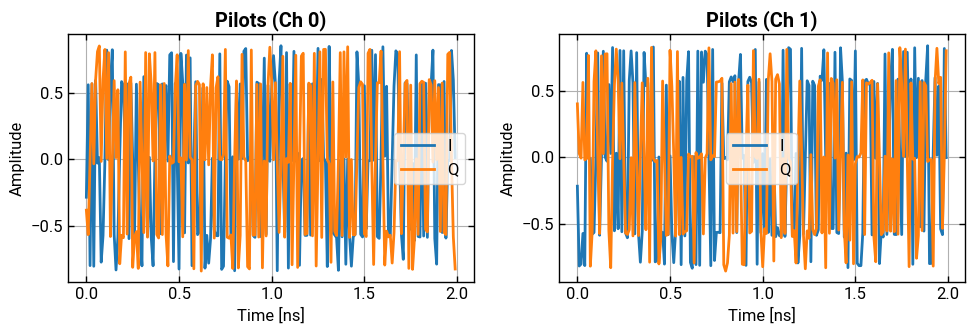

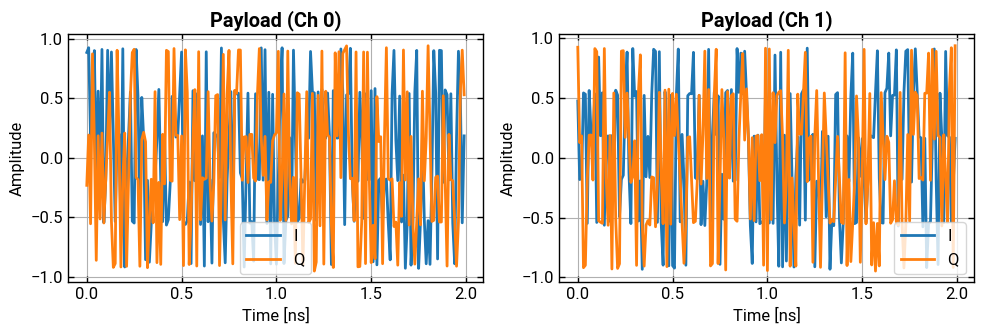

In [9]:
pilots.plot_waveform(show=True, num_symbols=200, title="Pilots")
payload.plot_waveform(show=True, num_symbols=200, title="Payload")


In [11]:
payload.mod_scheme = payload_mod_scheme
payload.mod_order = payload_mod_order
pilots.mod_scheme = pilots_mod_scheme
pilots.mod_order = pilots_mod_order


In [13]:
payload.resolve_symbols()
pilots.resolve_symbols()
payload.demap_symbols_hard()
pilots.demap_symbols_hard()


2026-02-27 10:22:13 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.
2026-02-27 10:22:13 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.


array([[1, 1, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 1, 1]], shape=(2, 266667), dtype=int8)

In [14]:
payload.evm()
payload.snr()
payload.ber()


2026-02-27 10:22:21 [INFO] [commstools/metrics.py] EVM Ch0: 3.24% (-29.80 dB)
2026-02-27 10:22:21 [INFO] [commstools/metrics.py] EVM Ch1: 3.23% (-29.82 dB)
2026-02-27 10:22:21 [INFO] [commstools/metrics.py] SNR Ch0: 29.80 dB
2026-02-27 10:22:21 [INFO] [commstools/metrics.py] SNR Ch1: 29.82 dB
2026-02-27 10:22:21 [INFO] [commstools/metrics.py] BER Ch0: 2.50e-07 (1/4000005 errors)
2026-02-27 10:22:21 [INFO] [commstools/metrics.py] BER Ch1: 2.50e-07 (1/4000005 errors)


array([2.49999688e-07, 2.49999688e-07])

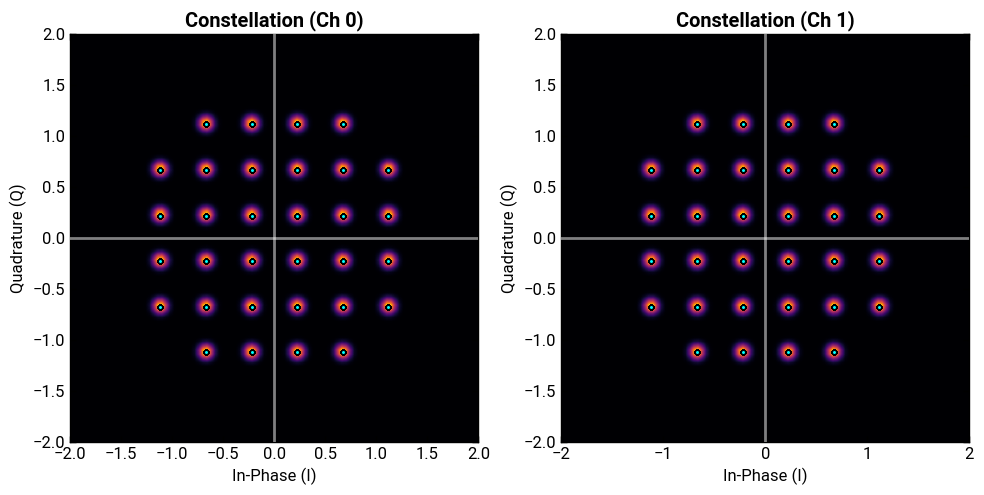

In [15]:
payload.plot_constellation(data="resolved", overlay_source=True, show=True)


In [16]:
pilots.evm()
pilots.snr()
pilots.ber()


2026-02-27 10:22:32 [INFO] [commstools/metrics.py] EVM Ch0: 3.25% (-29.77 dB)
2026-02-27 10:22:32 [INFO] [commstools/metrics.py] EVM Ch1: 3.23% (-29.81 dB)
2026-02-27 10:22:32 [INFO] [commstools/metrics.py] SNR Ch0: 29.77 dB
2026-02-27 10:22:32 [INFO] [commstools/metrics.py] SNR Ch1: 29.81 dB
2026-02-27 10:22:32 [INFO] [commstools/metrics.py] BER Ch0: 0.00e+00 (0/266667 errors)
2026-02-27 10:22:32 [INFO] [commstools/metrics.py] BER Ch1: 0.00e+00 (0/266667 errors)


array([0., 0.])

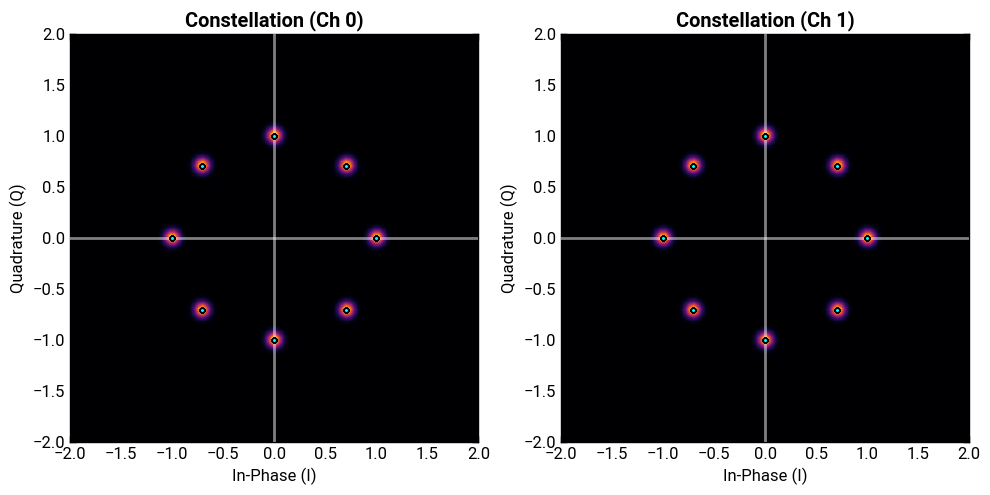

In [17]:
pilots.plot_constellation(data="resolved", overlay_source=True, show=True)
